In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import pandas as pd
from ai4neb import manage_RM
%matplotlib inline
import matplotlib as mpl
from astropy.table import Table
from astropy.io import fits
import pyneb as pn
mpl.rc('image', cmap='jet')
dir_RMs = 'RMs/'
dir_CSVs = 'CSVs/'

In [4]:
def to_hdf(file_, df, metadata=None):
    with pd.HDFStore(file_) as store:
        store.put('df', df)
        store.get_storer('df').attrs.metadata = metadata                     

def read_hdf(file_):                     
    with pd.HDFStore(file_) as store:
        df = store['df']
        metadata = store.get_storer('df').attrs.metadata
    return df, metadata
def get_data_17(datafile='data_BOND_17_2.hdf5', force=False):
    if not os.path.exists(dir_CSVs + datafile) or force:
        sel = """SELECT
                log10(O__3_500684A/H__1_486133A) as O3,  
                log10(N__2_658345A/H__1_486133A) as N2, 
                log10(BLND_372700A/H__1_486133A) as O2, 
                log10((NE_3_386876A + NE_3_396747A)/H__1_486133A) as Ne3,
                log10(AR_3_713579A/H__1_486133A) as Ar3,
                log10(HE_1_587564A/H__1_486133A) as He1,
                log10(BLND_436300A/O__3_500684A) as rO3,
                log10(BLND_575500A/N__2_658345A) as rN2,
                log10((S__2_673082A+S__2_671644A)/H__1_486133A) as S2,
                NITROGEN - OXYGEN as NO,
                OXYGEN as O,
                logU_mean as logU,
                SUBSTRING(com2, 5) as fr,
                SUBSTRING(com3, 6) as age,
                HbFrac
                FROM tab_17
                WHERE ref = 'BOND_2'"""
        db = pymysql.connect(host=os.environ['MdB_HOST'], 
                                user=os.environ['MdB_USER'], 
                                passwd=os.environ['MdB_PASSWD'], 
                                db=os.environ['MdB_DB_17'])    
        res = pd.read_sql(sel, con=db)
        res.fr = res.fr.astype('float64') 
        res.age = res.age.astype('float64')/1e6
        db.close()
        to_hdf(dir_CSVs + datafile, res, sel)
    else:
        res, sel = read_hdf(dir_CSVs + datafile)
    return res

res = get_data_17(force=False)
print(len(res))
mask = (res.HbFrac > 0.95) & (res.age < 5.5)
res = res[mask]
print(len(res))

210600
17550


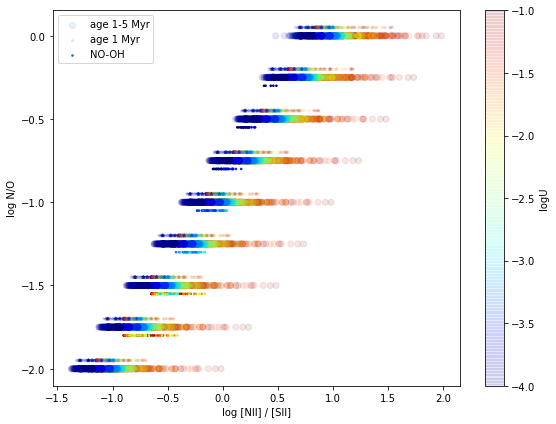

In [14]:
f, ax = plt.subplots(figsize=(8,6))
mask2 = res.age < 1.5
res2 = res[mask2]
NOvOH_EPM14 = lambda x: np.where(x < 8., -1.6, 1. * x - 9.6)
logU_M16 = lambda OH: 8.42 - 1.37 * (12 + OH)
mask3a = np.abs(NOvOH_EPM14(12+res.O) - res.NO ) < 0.2
mask3b = np.abs(logU_M16(res.O) - res.logU ) < 0.2
mask3 = mask3a & mask3b
res3 = res[mask3]
sc = ax.scatter(res.N2-res.S2, res.NO, c=res.logU, vmin=-4, vmax=-1, label='age 1-5 Myr', alpha=0.1)
sc2 = ax.scatter(res2.N2-res2.S2, res2.NO+0.05, marker='*', s=10, c=res2.logU, vmin=-4, vmax=-1, label='age 1 Myr', alpha=0.1)
sc3 = ax.scatter(res3.N2-res3.S2, res3.NO-0.05, marker='.', s=10, c=res3.logU, vmin=-4, vmax=-1, label='NO-OH', alpha=1)
ax.set_xlabel('log [NII] / [SII]')
ax.set_ylabel('log N/O')
cb = f.colorbar(sc, ax=ax)
cb.set_label('logU')
ax.legend()
f.tight_layout()
f.savefig('Figs/NOvsN2S2.png')

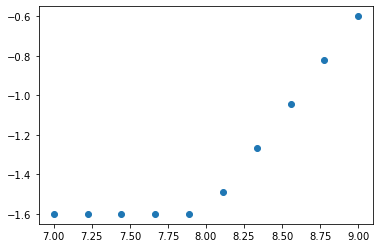

In [16]:
lOH12 = np.linspace(7,9,10)
plt.scatter(lOH12, NOvOH_EPM14(lOH12))